In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import math

import torch.optim as optim
import numpy as np
from tqdm import trange
from torch.utils.data import TensorDataset, DataLoader

class MMNN_BNN(nn.Module):
    def __init__(self, 
                 ranks=[1] + [16]*5 + [1], 
                 widths=[366]*6,
                 device="cpu",
                 prior_var=0.1,
                 ResNet=False):
        super().__init__()
        """
        MMNN_BNN: Bayesian Neural Network using MMNN structure
        
        Args:
            ranks: Output dimensions per layer [input_dim, ..., output_dim]
            widths: Width (number of basis functions) per layer
            device: Computing device
            prior_var: Prior variance for BNN layers (σ²/n_in scaling)
            ResNet: Whether to use residual connections
        """
        self.ranks = ranks
        self.widths = widths
        self.ResNet = ResNet
        self.depth = len(widths)
        self.device = device
        self.prior_var = prior_var
        
        # Build layer sizes: [input, width1, rank1, width2, rank2, ..., output]
        fc_sizes = [ranks[0]]
        for j in range(self.depth):
            fc_sizes += [widths[j], ranks[j+1]]
        
        # Initialize layers
        self.fcs = nn.ModuleList()
        self.bnn_params = nn.ParameterDict()  # BNN variance parameters
        
        for j in range(len(fc_sizes)-1):
            # print(f"Layer {j}: {fc_sizes[j]} -> {fc_sizes[j+1]}")
            fc = nn.Linear(fc_sizes[j], fc_sizes[j+1], device=device)
            self.fcs.append(fc)
            
            # For W,b layers (even indices): Add BNN treatment
            if j % 2 == 0:
                # Freeze the mean parameters (W, b)
                fc.weight.requires_grad = False
                fc.bias.requires_grad = False
                
                # Store fixed means
                self.register_buffer(f'W_mean_{j}', fc.weight.clone())
                self.register_buffer(f'b_mean_{j}', fc.bias.clone())
                
                # Initialize variance parameters (log-parameterization for stability)
                # Depth-dependent prior variance
                layer_depth = j // 2  # Convert to layer index
                layer_prior_var = self.get_layer_prior_var(layer_depth, self.prior_var)
                n_in = fc_sizes[j]
                init_log_var = math.log(layer_prior_var / n_in)  # σ²/n_in scaling
                
                self.bnn_params[f'W_log_var_{j}'] = nn.Parameter(
                    torch.full_like(fc.weight, init_log_var)
                )
                self.bnn_params[f'b_log_var_{j}'] = nn.Parameter(
                    torch.full_like(fc.bias, init_log_var)
                )
    def get_layer_prior_var(self, layer_depth, base_var=0.1):
        """
        Depth-dependent prior variance
        
        Args:
            layer_depth: 0 for first layer, increasing with depth
            base_var: Base variance for last layer
        """
        # Exponential decay with depth (deeper = higher variance allowed)
        depth_factor = 10 ** (-2 * (self.depth - 1 - layer_depth) / (self.depth - 1))
        return base_var * depth_factor
    def sample_bnn_params(self):
        """Sample W,b parameters from variational posterior"""
        sampled_params = {}
        
        for name, param in self.bnn_params.items():
            if 'W_log_var' in name:
                layer_idx = name.split('_')[-1]
                
                # Get mean and variance
                W_mean = getattr(self, f'W_mean_{layer_idx}')
                W_var = torch.exp(param)  # Convert from log-variance
                
                # Sample using reparameterization trick
                eps = torch.randn_like(W_mean)
                W_sample = W_mean + torch.sqrt(W_var) * eps
                sampled_params[f'W_{layer_idx}'] = W_sample
                
            elif 'b_log_var' in name:
                layer_idx = name.split('_')[-1]
                
                b_mean = getattr(self, f'b_mean_{layer_idx}')
                b_var = torch.exp(param)
                
                eps = torch.randn_like(b_mean)
                b_sample = b_mean + torch.sqrt(b_var) * eps
                sampled_params[f'b_{layer_idx}'] = b_sample
        
        return sampled_params
    
    def forward(self, x, n_samples=1):
        """
        Forward pass with Monte Carlo sampling
        
        Args:
            x: Input tensor
            n_samples: Number of MC samples for inference
        
        Returns:
            output: Mean prediction (if n_samples=1) or samples
        """
        if n_samples == 1:
            return self._forward_single(x)
        else:
            return self._forward_mc(x, n_samples)
    
    def _forward_single(self, x):
        """Single forward pass for training"""
        sampled_params = self.sample_bnn_params()
        
        for j in range(self.depth):
            if self.ResNet and 0 < j < self.depth-1:
                x_id = x.clone()
            
            # BNN layer (W,b with uncertainty)
            layer_idx = 2 * j
            if f'W_{layer_idx}' in sampled_params:
                W = sampled_params[f'W_{layer_idx}']
                b = sampled_params[f'b_{layer_idx}']
                # print(W.t().shape, b.shape,x.shape)
                x = F.linear(x, W, b)
            else:
                x = self.fcs[layer_idx](x)
            
            x = torch.relu(x)
            
            # Deterministic A layer
            x = self.fcs[layer_idx + 1](x)
            
            # ResNet connection
            if self.ResNet and 0 < j < self.depth-1:
                n = min(x.shape[1], x_id.shape[1])
                x[:, :n] = x[:, :n] + x_id[:, :n]
        
        return x
    
    def _forward_mc(self, x, n_samples):
        """Multiple forward passes for uncertainty estimation"""
        outputs = []
        for _ in range(n_samples):
            outputs.append(self._forward_single(x))
        return torch.stack(outputs, dim=0)  # [n_samples, batch_size, output_dim]
    
    def kl_divergence(self):
        """Compute KL divergence between posterior and prior"""
        kl_div = 0.0
        
        for name, log_var_param in self.bnn_params.items():
            if 'W_log_var' in name:
                layer_idx = name.split('_')[-1]
                layer_idx_int = int(layer_idx)
                n_in = self.fcs[layer_idx_int].in_features
                
                # Prior: N(W_mean, σ²/n_in * I)
                prior_log_var = math.log(self.prior_var / n_in)
                
            elif 'b_log_var' in name:
                # Prior: N(b_mean, σ² * I) 
                prior_log_var = math.log(self.prior_var)
            
            # KL[N(μ, σ²) || N(μ, σ_p²)] = 1/2 * [log(σ_p²/σ²) + σ²/σ_p² - 1]
            posterior_var = torch.exp(log_var_param)
            prior_var = math.exp(prior_log_var)
            
            kl_layer = 0.5 * (
                prior_log_var - log_var_param + 
                posterior_var / prior_var - 1.0
            )
            kl_div += kl_layer.sum()
        
        return kl_div
    
    def elbo_loss(self, x, y, n_samples=1, beta=1.0):
        """
        Compute ELBO loss for training
        
        Args:
            x, y: Input and target
            n_samples: MC samples for likelihood estimation
            beta: KL weighting (β-VAE style)
        """
        # Likelihood term: E_q[log p(y|x,θ)]
        if n_samples == 1:
            y_pred = self._forward_single(x)
            log_likelihood = -0.5 * F.mse_loss(y_pred, y, reduction='sum')
        else:
            y_samples = self._forward_mc(x, n_samples)  # [n_samples, batch, output]
            log_likelihood = 0.0
            for i in range(n_samples):
                log_likelihood += -0.5 * F.mse_loss(y_samples[i], y, reduction='sum')
            log_likelihood /= n_samples
        
        # KL term: KL[q(θ)||p(θ)]
        kl_div = self.kl_divergence()
        
        # ELBO = E[log p(y|x,θ)] - β * KL[q(θ)||p(θ)]
        elbo = log_likelihood - beta * kl_div
        
        # Return negative ELBO for minimization
        return -elbo, log_likelihood, kl_div

In [2]:
# import torch.optim as optim
# import numpy as np
# from tqdm import trange
# from torch.utils.data import TensorDataset, DataLoader

# def train_mmnn_bnn(model, train_loader, val_loader=None, 
#                    epochs=1000, lr=1e-3, beta_schedule=None, 
#                    n_mc_samples=1, device='cpu'):
#     """
#     Training scheme for MMNN_BNN
    
#     Args:
#         model: MMNN_BNN instance
#         train_loader: Training data loader
#         val_loader: Validation data loader (optional)
#         epochs: Number of training epochs
#         lr: Learning rate
#         beta_schedule: Function for KL annealing (epoch -> beta)
#         n_mc_samples: MC samples during training (1 for efficiency)
#         device: Computing device
#     """
    
#     # Optimizer - separate learning rates for different parameter types
#     bnn_params = list(model.bnn_params.parameters())
#     bnn_param_ids = {id(p) for p in bnn_params}
#     mlp_params = [p for p in model.parameters() if p.requires_grad and id(p) not in bnn_param_ids]
    
#     optimizer = optim.Adam([
#         {'params': bnn_params, 'lr': lr, 'name': 'bnn'},
#         {'params': mlp_params, 'lr': lr * 5, 'name': 'mlp'}  # Higher LR for A,c params
#     ])
    
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.8)

#     # scheduler = optim.lr_scheduler.StepLR(optimizer,step_size = 50, gamma=0.99)
    
#     # Default beta schedule: gradual annealing from 0 to 1
#     if beta_schedule is None:
#         beta_schedule = lambda epoch: min(1.0, epoch / (epochs * 0.1))
    
#     # Training history
#     history = {
#         'train_loss': [], 'train_likelihood': [], 'train_kl': [],
#         'val_loss': [], 'val_rmse': [], 'val_coverage': []
#     }
    
#     model.train()
#     pbar = trange(epochs, desc="Training MMNN_BNN")
    
#     for epoch in pbar:
#         # Current beta for KL annealing
#         beta = beta_schedule(epoch)
        
#         # Training phase
#         epoch_loss, epoch_likelihood, epoch_kl = 0.0, 0.0, 0.0
#         num_batches = 0
        
#         for batch_x, batch_y in train_loader:
#             batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
#             optimizer.zero_grad()
            
#             # Compute ELBO loss
#             loss, likelihood, kl_div = model.elbo_loss(
#                 batch_x, batch_y, n_samples=n_mc_samples, beta=beta
#             )
            
#             # Backward pass
#             loss.backward()
            
#             # Gradient clipping for stability
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
#             optimizer.step()
            
#             # Accumulate metrics
#             epoch_loss += loss.item()
#             epoch_likelihood += likelihood.item()
#             epoch_kl += kl_div.item()
#             num_batches += 1
        
#         # Average training metrics
#         avg_loss = epoch_loss / num_batches
#         avg_likelihood = epoch_likelihood / num_batches
#         avg_kl = epoch_kl / num_batches
        
#         history['train_loss'].append(avg_loss)
#         history['train_likelihood'].append(avg_likelihood)
#         history['train_kl'].append(avg_kl)
        
#         # Validation phase
#         val_metrics = {}
#         if val_loader is not None:
#             val_metrics = evaluate_mmnn_bnn(model, val_loader, device)
#             history['val_loss'].append(val_metrics['loss'])
#             history['val_rmse'].append(val_metrics['rmse'])
#             history['val_coverage'].append(val_metrics['coverage_95'])
            
#             scheduler.step(val_metrics['loss'])
        
#         # Update progress bar
#         pbar_dict = {
#             'loss': f"{avg_loss:.3e}",
#             'likelihood': f"{avg_likelihood:.3e}", 
#             'kl': f"{avg_kl:.3e}",
#             'beta': f"{beta:.3f}"
#         }
#         if val_metrics:
#             pbar_dict.update({
#                 'val_rmse': f"{val_metrics['rmse']:.3e}",
#                 'val_cov': f"{val_metrics['coverage_95']:.2f}"
#             })
        
#         pbar.set_postfix(pbar_dict)
        
#         # Early stopping on KL explosion
#         if avg_kl > 1e6:
#             print(f"Training stopped at epoch {epoch}: KL divergence exploded")
#             break
    
#     return history


In [14]:
def train_mmnn_bnn(model, train_loader, val_loader=None, 
                   epochs=1000, lr=1e-3, beta_schedule=None, 
                   n_mc_samples=1, device='cpu'):
    """
    Training scheme for MMNN_BNN
    
    Args:
        model: MMNN_BNN instance
        train_loader: Training data loader
        val_loader: Validation data loader (optional)
        epochs: Number of training epochs
        lr: Learning rate
        beta_schedule: Function for KL annealing (epoch -> beta)
        n_mc_samples: MC samples during training (1 for efficiency)
        device: Computing device
    """
    
    # Optimizer - separate learning rates for different parameter types
    bnn_params = list(model.bnn_params.parameters())
    bnn_param_ids = {id(p) for p in bnn_params}
    mlp_params = [p for p in model.parameters() if p.requires_grad and id(p) not in bnn_param_ids]
    
    optimizer = optim.Adam([
        {'params': bnn_params, 'lr': lr, 'name': 'bnn'},
        {'params': mlp_params, 'lr': lr * 5, 'name': 'mlp'}  # Higher LR for A,c params
    ])
    
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)  # Decay by 5% each epoch
    
    # Default beta schedule: gradual annealing from 0 to 1
    if beta_schedule is None:
        beta_schedule = lambda epoch: min(1.0, epoch / (epochs /200))
    
    # Training history
    history = {
        'train_loss': [], 'train_likelihood': [], 'train_kl': [],
        'val_loss': [], 'val_rmse': [], 'val_coverage': []
    }
    
    model.train()
    pbar = trange(epochs, desc="Training MMNN_BNN")
    
    for epoch in pbar:
        # Current beta for KL annealing
        beta = beta_schedule(epoch)
        
        # Training phase
        epoch_loss, epoch_likelihood, epoch_kl = 0.0, 0.0, 0.0
        num_batches = 0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            
            # Compute ELBO loss
            loss, likelihood, kl_div = model.elbo_loss(
                batch_x, batch_y, n_samples=n_mc_samples, beta=beta
            )
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Accumulate metrics
            epoch_loss += loss.item()
            epoch_likelihood += likelihood.item()
            epoch_kl += kl_div.item()
            num_batches += 1
        
        # Average training metrics
        avg_loss = epoch_loss / num_batches
        avg_likelihood = epoch_likelihood / num_batches
        avg_kl = epoch_kl / num_batches
        
        history['train_loss'].append(avg_loss)
        history['train_likelihood'].append(avg_likelihood)
        history['train_kl'].append(avg_kl)
        
        # Validation phase
        val_metrics = {}
        if val_loader is not None:
            val_metrics = evaluate_mmnn_bnn(model, val_loader, device)
            history['val_loss'].append(val_metrics['loss'])
            history['val_rmse'].append(val_metrics['rmse'])
            history['val_coverage'].append(val_metrics['coverage_95'])
            
            scheduler.step()
        
        # Update progress bar
        pbar_dict = {
            'loss': f"{avg_loss:.3e}",
            'likelihood': f"{avg_likelihood:.3e}", 
            'kl': f"{avg_kl:.3e}",
            'beta': f"{beta:.3f}"
        }
        if val_metrics:
            pbar_dict.update({
                'val_rmse': f"{val_metrics['rmse']:.3e}",
                'val_cov': f"{val_metrics['coverage_95']:.2f}"
            })
        
        pbar.set_postfix(pbar_dict)
        
        # Early stopping on KL explosion
        if avg_kl > 1e6:
            print(f"Training stopped at epoch {epoch}: KL divergence exploded")
            break
    
    return history

In [15]:
def evaluate_mmnn_bnn(model, data_loader, device, n_mc_samples=50):
    """
    Evaluate MMNN_BNN with uncertainty quantification
    
    Args:
        model: Trained MMNN_BNN
        data_loader: Data loader for evaluation
        device: Computing device
        n_mc_samples: MC samples for uncertainty estimation
    
    Returns:
        metrics: Dictionary of evaluation metrics
    """
    model.eval()
    
    all_targets = []
    all_means = []
    all_stds = []
    total_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # Monte Carlo sampling for uncertainty
            mc_samples = model._forward_mc(batch_x, n_mc_samples)  # [n_samples, batch, output]
            
            # Compute statistics
            pred_mean = mc_samples.mean(dim=0)  # [batch, output]
            pred_std = mc_samples.std(dim=0)    # [batch, output]
            
            # Accumulate for metrics
            all_targets.append(batch_y.cpu())
            all_means.append(pred_mean.cpu())
            all_stds.append(pred_std.cpu())
            
            # Loss computation
            loss, _, _ = model.elbo_loss(batch_x, batch_y, n_samples=1, beta=1.0)
            total_loss += loss.item()
            num_batches += 1
    
    # Concatenate all predictions
    targets = torch.cat(all_targets, dim=0)  # [total_samples, output_dim]
    means = torch.cat(all_means, dim=0)
    stds = torch.cat(all_stds, dim=0)
    
    # Compute metrics
    metrics = {}
    
    # Predictive performance
    metrics['loss'] = total_loss / num_batches
    metrics['rmse'] = torch.sqrt(torch.mean((targets - means)**2)).item()
    metrics['mae'] = torch.mean(torch.abs(targets - means)).item()
    
    # Uncertainty calibration
    errors = torch.abs(targets - means)
    
    # Coverage probabilities (assuming Gaussian predictive distribution)
    z_scores = errors / (stds + 1e-8)  # Avoid division by zero
    
    # 68% coverage (±1σ)
    metrics['coverage_68'] = (z_scores <= 1.0).float().mean().item()
    
    # 95% coverage (±1.96σ)  
    metrics['coverage_95'] = (z_scores <= 1.96).float().mean().item()
    
    # Average prediction interval width
    metrics['avg_uncertainty'] = stds.mean().item()
    
    # Calibration: correlation between predicted uncertainty and actual error
    if stds.numel() > 1:
        correlation = torch.corrcoef(torch.stack([stds.flatten(), errors.flatten()]))[0,1]
        metrics['uncertainty_correlation'] = correlation.item() if not torch.isnan(correlation) else 0.0
    else:
        metrics['uncertainty_correlation'] = 0.0
    
    return metrics



In [16]:
def predict_with_uncertainty(model, x, n_samples=100, confidence_level=0.95):
    """
    Make predictions with uncertainty intervals
    
    Args:
        model: Trained MMNN_BNN
        x: Input tensor
        n_samples: MC samples for uncertainty
        confidence_level: Confidence level for intervals
        
    Returns:
        mean: Predictive mean
        std: Predictive standard deviation  
        lower: Lower confidence bound
        upper: Upper confidence bound
    """
    model.eval()
    
    with torch.no_grad():
        # Monte Carlo sampling
        samples = model._forward_mc(x, n_samples)  # [n_samples, batch, output]
        
        # Compute statistics
        mean = samples.mean(dim=0)
        std = samples.std(dim=0)
        
        # Confidence intervals (assuming Gaussian)
        from scipy.stats import norm
        z_score = norm.ppf((1 + confidence_level) / 2)
        
        lower = mean - z_score * std
        upper = mean + z_score * std
        
    return mean, std, lower, upper



In [17]:
# Training configuration example
def create_training_config():
    """Example training configuration"""
    return {
        'epochs': 2000,
        'lr': 1e-3,
        'beta_schedule': lambda epoch: min(1.0, epoch / 200),  # Linear annealing over 200 epochs
        'n_mc_samples': 1,  # Single sample during training for efficiency
        'batch_size': 32,
        'val_interval': 50,  # Evaluate every 50 epochs
    }

In [18]:
# # Simple test function
# def test_mmnn_bnn():
#     # Generate synthetic data: y = sin(3*pi*x) + noise
#     torch.manual_seed(42)
#     np.random.seed(42)
    
#     x_train = torch.linspace(-1, 1, 1000).unsqueeze(1)
#     y_train = func(3 * np.pi * x_train) + 0.1 * torch.randn_like(x_train)
    
#     x_test = torch.linspace(-1.5, 1.5, 100).unsqueeze(1)
#     y_test = func(3 * np.pi * x_test)
    
#     # Data loaders
#     train_dataset = TensorDataset(x_train, y_train)
#     train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
#     # Model
#     model = MMNN_BNN(ranks=[1]+[32]*3+[1], widths=[256]*4,prior_var=0.001)
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
#     # Training
#     print("Training MMNN_BNN...")
#     for epoch in range(5000):
#         total_loss = 0
#         for batch_x, batch_y in train_loader:
#             optimizer.zero_grad()
            
#             # ELBO loss
#             y_pred = model(batch_x)
#             likelihood = -0.5 * torch.nn.functional.mse_loss(y_pred, batch_y, reduction='sum')
#             kl_div = model.kl_divergence()
            
#             # Anneal KL weight
#             beta = min(1.0, epoch / 100)
#             loss = -(likelihood - beta * kl_div)
            
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#         scheduler.step()
        
#         if epoch % 500 == 0:
#             print(f"Epoch {epoch}, Loss: {total_loss:.3f}")
    
#             # Test with uncertainty
#             print("\nTesting with uncertainty...")
#             model.eval()
#             with torch.no_grad():
#                 # Multiple samples for uncertainty
#                 n_samples = 50
#                 predictions = []
#                 for _ in range(n_samples):
#                     pred = model(x_test)
                    
#                     predictions.append(pred)
                
#                 predictions = torch.stack(predictions)
#                 mean_pred = predictions.mean(dim=0)
#                 std_pred = predictions.std(dim=0)

            
#             # Plot results
#             plt.figure(figsize=(10, 6))
            
#             # Training data
#             plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.5, s=20, label='Training data')
            
#             # True function
#             plt.plot(x_test.numpy(), y_test.numpy(), 'r-', linewidth=2, label='True function')
            
#             # Predictions with uncertainty
#             plt.plot(x_test.numpy(), mean_pred.numpy(), 'b-', linewidth=2, label='Mean prediction')
#             plt.fill_between(
#                 x_test.numpy().flatten(),
#                 (mean_pred - 2*std_pred).numpy().flatten(),
#                 (mean_pred + 2*std_pred).numpy().flatten(),
#                 alpha=0.3, color='blue', label='95% confidence'
#             )
            
#             plt.xlabel('x')
#             plt.ylabel('y')
#             plt.title('MMNN_BNN: sin(3πx) with Uncertainty')
#             plt.legend()
#             plt.grid(True)
#             plt.show()
    
#     # Compute metrics
#     rmse = torch.sqrt(torch.mean((mean_pred - y_test)**2))
#     coverage = ((y_test >= mean_pred - 2*std_pred) & (y_test <= mean_pred + 2*std_pred)).float().mean()
    
#     print(f"\nResults:")
#     print(f"RMSE: {rmse:.4f}")
#     print(f"95% Coverage: {coverage:.3f}")
#     print(f"Average uncertainty: {std_pred.mean():.4f}")
    
#     return model, mean_pred, std_pred

In [19]:
import matplotlib.pyplot as plt

In [9]:
# model, predictions, uncertainties = test_mmnn_bnn()

In [63]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
# func = lambda x: torch.cos(10*torch.pi*torch.abs(x)**(1.4))+0.5*torch.cos(6*torch.pi*torch.abs(x)**(1.6))
func = lambda x: torch.sin(5 * np.pi * x)  # Simpler function for testing
# Quick integration test


def test_mmnn_bnn_integration(model):
    # Generate data
    torch.manual_seed(42)
    x_train = torch.linspace(-1, 1, 1000).unsqueeze(1)
    
    # y_train = func(2 * np.pi * x_train) + 0.00 * torch.randn_like(x_train)
    y_train = func(x_train) + 0.01 * torch.randn_like(x_train)
    
    x_val = torch.linspace(-1.2, 1.2, 50).unsqueeze(1)
    # y_val = func(2 * np.pi * x_val) + 0.000 * torch.randn_like(x_val)
    y_val = func(x_val) + 0.0 * torch.randn_like(x_val)
    
    # Data loaders
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True)
    val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=100)
    
    # Create model
    
    
    
    
    # Train
    print("Testing MMNN_BNN training...")
    history = train_mmnn_bnn(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=500,
        lr=1e-3,
        beta_schedule=lambda epoch: min(1.0, epoch / 200),
        n_mc_samples=1
    )
    
    # Test prediction
    print("Testing uncertainty prediction...")
    x_test = torch.linspace(-1.5, 1.5, 80).unsqueeze(1)
    
    mean, std, lower, upper = predict_with_uncertainty(
        model, x_test, n_samples=30, confidence_level=0.95
    )
    
    # Plot
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    if history['val_loss']:
        plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Progress')
    
    plt.subplot(1, 2, 2)
    plt.scatter(x_train, y_train, alpha=0.6, s=20, label='Train')
    # plt.plot(x_test, func(2 * np.pi * x_test), 'r-', label='True')
    plt.plot(x_test, func(x_test), 'r-', label='True')
    plt.plot(x_test, mean, 'b-', label='Prediction')
    plt.fill_between(x_test.flatten(), lower.flatten(), upper.flatten(), 
                     alpha=0.3, label='95% CI')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Predictions with Uncertainty')
    
    plt.tight_layout()
    plt.show()
    
    # Check if working
    final_loss = history['train_loss'][-1]
    coverage = history['val_coverage'][-1] if history['val_coverage'] else 0.5
    
    print(f"\nTest Results:")
    print(f"Final loss: {final_loss:.3f}")
    print(f"Val coverage: {coverage:.3f}")
    print(f"Expected coverage: ~0.95")
    
    success = (final_loss < 1000) and (0.8 < coverage < 1.0)
    print(f"Test {'PASSED' if success else 'FAILED'}")
    
    return model, history


    

In [67]:
model = MMNN_BNN(
        ranks=[1]+[32]*5+[1],  # Example ranks
        widths=[350]*6, 
        prior_var=0.05
    )

In [ ]:

model, history = test_mmnn_bnn_integration(model)

Testing MMNN_BNN training...


Training MMNN_BNN:  46%|████▌     | 228/500 [00:21<00:25, 10.74it/s, loss=3.408e+04, likelihood=-1.766e+00, kl=3.408e+04, beta=1.000, val_rmse=3.320e-01, val_cov=0.86]

Testing uncertainty prediction...


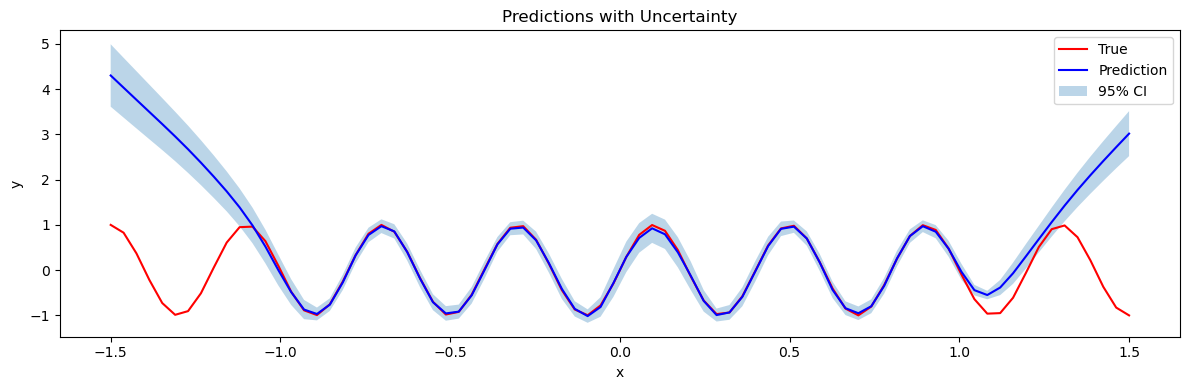

In [66]:
# Test prediction
print("Testing uncertainty prediction...")
x_test = torch.linspace(-1.5, 1.5, 80).unsqueeze(1)

mean, std, lower, upper = predict_with_uncertainty(
    model, x_test, n_samples=50, confidence_level=0.95
)

# Plot
plt.figure(figsize=(12, 4))


plt.plot(x_test, func(x_test), 'r-', label='True')
plt.plot(x_test, mean, 'b-', label='Prediction')
plt.fill_between(x_test.flatten(), lower.flatten(), upper.flatten(), 
                    alpha=0.3, label='95% CI')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Predictions with Uncertainty')

plt.tight_layout()
plt.show()